In [2]:
#updates/bug fixes
# Changed the visualization so it shows bacteria gene values
# Fixed bug where bacteria would be updated twice in the update function because they moved to a new spot
#     Added Flag variable to bacteria that becomes true when the bacteria updates and is reset at the end of the update function
# Changed the reproduction function so bacteria reproduce more in favorable conditions
# Changed the movement function so bacteria are more active in nutrient dense areas
# Changed board size to 36x36 for speed
# Fixed a couple hard code bugs in the board class so now the dimensions are always in terms of ncols and nrows instead of fixed numbers
# Fixed bug in in_region function so the upper bounds no longer throws error (changed <= to <)
# Deleted nutrient gene from the death function, current setup made no sense. The bacteria would die if the nutrients where too high. Could be added back in if works different.
# Added bacteria count function
# Track bacteria count over simulation and graph


# Future plans to add
# Will scale the color mapping so that after the bacteria genes hit a certain value to color stops changing
# Will create functions to track average gene values at each iteration to plot

In [3]:
#imports
import random 
import numpy as np
import math
import matplotlib.pyplot as plt
import time  
from IPython.display import display, clear_output
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.cbook import get_sample_data
import random

def imscatter(x, y, image, ax=None, zoom=1):
    if ax is None:
        ax = plt.gca()
    try:
        image = plt.imread(image)
    except TypeError:
        pass
    im = OffsetImage(image, zoom=zoom)
    x, y = np.atleast_1d(x, y)
    artists = []
    for x0, y0 in zip(x, y):
        ab = AnnotationBbox(im, (x0, y0), xycoords='data', \
                            frameon=False)
        artists.append(ax.add_artist(ab))
    ax.update_datalim(np.column_stack([x, y]))
    ax.autoscale()
    return artists
#from inclass assignment

In [4]:
class bacteria():
    
    __slots__ = ['x', 'y', 'antibiotic_resistance_gene', 'nutrient_gene', 'temperature_gene', 'toxin_gene', 'mutation_rate', 'reproduction_rate', 'visited']
    
    def __init__(self, x = random.randint(0,215),y = random.randint(0,215), anti = 0, nutri = 0, temp = 0, toxin = 0, mutation_rate=0.5, reproduction_rate=0.5):
        """
        Creates new bacteria object with random position and genes
        :x: x position of bacteria
        :y: y position of bacteria
        :gene_seed: float value to add to all randomly initialized gene values
        :mutation_rate: the mutation rate for bacteria
        """
        self.x = x
        self.y = y
        
        #visited flag for
        self.visited = False
        
        #initialize all genes to random values between [0, 0.2] + gene_seed
        self.antibiotic_resistance_gene = np.random.rand()/5 + anti
        self.nutrient_gene = np.random.rand()/5 + nutri
        self.temperature_gene = np.random.rand()/5 + temp
        self.toxin_gene = np.random.rand()/5 + toxin
        
        self.mutation_rate = mutation_rate
        self.reproduction_rate = reproduction_rate
        
    
    def set_position(self, x, y):
        """
        Sets the position of self using passed arguments
        """
        self.x = x
        self.y = y
        return
    
    def get_pos(self):
        return self.x, self.y
    
    def movement(self, board):
        """
        Randomly move bacteria up to two units in the x and y directions based on nutrients and antibiotics
        """
        if board.get_nutrients(self.x, self.y) > 0.5: #bacteria will move more if in high level of nutrients
            new_x = self.x + np.random.randint(-2, 3)
            new_y = self.y + np.random.randint(-2, 3)
        else:
            new_x = self.x + np.random.randint(-1, 2)
            new_y = self.y + np.random.randint(-1, 2)
            
        if new_x < 0:
            new_x = 0
        if new_x >= board.ncols:
            new_x = board.ncols - 1

        if new_y < 0:
            new_y = 0
        if new_y >= board.nrows:
            new_y = board.nrows - 1
            
        if not board.get_bacteria(new_x, new_y):
            board.remove_bacteria(self.x,self.y)
            self.x = new_x
            self.y = new_y
            board.add_bacteria(self.x, self.y, self)
            
        return

    
    def reproduce(self, board):
        """
        Returns a new bacteria with genes based off of parent (self)
        
        Reproduction rate boosted if in nutrient dense area
        Reproduction rate decreased if in high anti-biotics
        
        if np.random.rand() < self.reproduction_rate:
            for new_x in range(self.x - 1, self.x + 2):
                for new_y in range(self.y - 1, self.y + 2):
                    if new_x >= 0 and new_x < 216 and new_y >= 0 and new_y < 216 and not board.get_bacteria(new_x, new_y):
                        newbac = bacteria(new_x, new_y, self.antibiotic_resistance_gene, self.nutrient_gene, self.temperature_gene, self.toxin_gene)
                        board.add_bacteria(new_x, new_y, newbac)
                        return newbac
        """
        #first option could be implemented for multiple offspring at once, would just have to change update function
        
        if np.random.rand() < (self.reproduction_rate * (1+board.get_nutrients(self.x, self.y))/(1+board.get_antibiotics(self.x, self.y))):  # randomly chooses value from [0,1], if value is less than reproduction rate * (nutrient level/antibiotic level) it reproduces
            openings = board.get_openings(self.y, self.x)
            if openings is not None:
                loc = random.randint(0,len(openings)-1)
                newbac = bacteria(openings[loc][1], openings[loc][0], self.antibiotic_resistance_gene, self.nutrient_gene, self.temperature_gene, self.toxin_gene, self.mutation_rate, self.reproduction_rate)
                board.add_bacteria(openings[loc][1], openings[loc][0], newbac)
        return
    
    
    def mutate(self):
        """
        Randomly calculate if bacteria will mutate
        If true, randomly add from a N(0, 0.1) distribution
        genes mutate independently
        """
        if np.random.rand() < self.mutation_rate:
            self.antibiotic_resistance_gene += 0.1 * np.random.randn()
        if np.random.rand() < self.mutation_rate:
            self.nutrient_gene += 0.1 * np.random.randn()
        if np.random.rand() < self.mutation_rate:
            self.temperature_gene += 0.1 * np.random.randn()
        if np.random.rand() < self.mutation_rate:
            self.toxin_gene += 0.1 * np.random.randn()
    
    def death(self, the_board):
        """
        Calculate something related to the current conditions the bacteria is experiencing to see if it dies based on its genes.
        :external_condition_value: could be anything such as temperature, antibiotics level, white blood cell count, etc
        """
        if self.antibiotic_resistance_gene < the_board.get_antibiotics(self.x,self.y):
            return True
#         if self.nutrient_gene < the_board.get_nutrients(self.x,self.y):
#             return True
        if self.toxin_gene < the_board.get_toxin(self.x,self.y):
            return True
        if self.temperature_gene < the_board.get_temperature(self.x,self.y):
            return True
        return False
    
    def update(self, board):
        '''
        updates a bacteria
        calls all other methods (movement, reproduce, mutate, death, etc)
        returns new x and y coords of bacteria
        '''
        if self.death(board):
            board.remove_bacteria(self.x, self.y)
            return None
        self.movement(board)
        self.mutate()
        self.reproduce(board)
        board.toxins(self)
        return (self.x, self.y)
    
    def draw(self):
        image_path = 'bacteria.jpg'
        imscatter(self.x, self.y, image_path, zoom=0.8)
        return

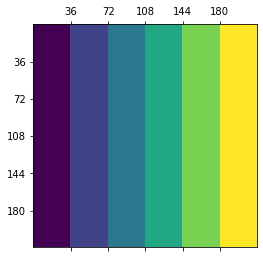

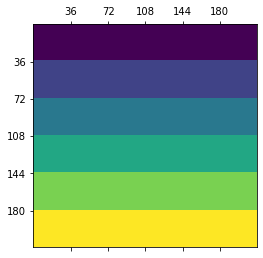

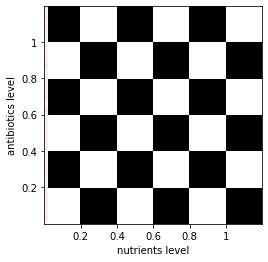

Bacteria Count:  216


In [5]:
#https://stackoverflow.com/questions/10194482/custom-matplotlib-plot-chess-board-like-table-with-colored-cells
class board():
    
    __slots__ = ['nrows', 'ncols', '_nutrients', '_antibiotics', '_temperature','_toxins', '_bacteria']
    
    
    def __init__(self, nrows = 9, ncols = 9):
        '''
        Initializes board with given rows and columns
        creates nutrients, anti, toxins, and bacteria private attributes
        currently initializes bacteria in column 0, could easily change later
        '''
        self.nrows = nrows
        self.ncols = ncols
        self._nutrients = np.zeros((self.nrows,self.ncols))
        self._antibiotics = np.zeros((self.nrows,self.ncols))
        self._toxins = np.zeros((self.nrows,self.ncols))
        self._temperature = np.zeros((self.nrows,self.ncols))
        self._bacteria = np.full([self.nrows,self.ncols], None)
        
        #currently initializes bacteria in column 0
        for y_val in range(nrows):
            self._bacteria[y_val,0] = bacteria(0,y_val)
        #print("nutrient initialization: (antibiotics and toxins have same init)")
        #print(self._nutrients)
        #print('\n')
        #print("bacteria locations:")
        #print(self._bacteria)
        self.nutrients()
        self.antibiotics()
    
    def nutrients(self):
        '''
        displays nutrients attribute with random nonzero entry added
        '''
        for col in range(self.ncols):
            if col < self.ncols/6:
                self._nutrients[:,col] = 0
            elif col < 2*self.ncols/6:
                self._nutrients[:,col] = .2
            elif col < 3*self.ncols/6:
                self._nutrients[:,col] = .4
            elif col < 4*self.ncols/6:
                self._nutrients[:,col] = .6
            elif col < 5*self.ncols/6:
                self._nutrients[:,col] = .8
            else:
                self._nutrients[:,col] = 1
        
        plt.matshow(self._nutrients)
        
        x_temp = self.ncols//6
        y_temp = self.nrows//6
        x_ticks = [x_temp,2*x_temp,3*x_temp,4*x_temp,5*x_temp]
        y_ticks = [y_temp,2*y_temp,3*y_temp,4*y_temp,5*y_temp]
        plt.xticks(x_ticks,x_ticks)
        plt.yticks(y_ticks,y_ticks)
        plt.show()
        return

    def antibiotics(self):
        '''
        displays antibiotics attribute with random nonzero entry added
        '''
        for row in range(self.nrows):
            if row < self.nrows/6:
                self._antibiotics[row,:] = 0
            elif row < 2*self.nrows/6:
                self._antibiotics[row,:] = .2
            elif row < 3*self.nrows/6:
                self._antibiotics[row,:] = .4
            elif row < 4*self.nrows/6:
                self._antibiotics[row,:] = .6
            elif row < 5*self.nrows/6:
                self._antibiotics[row,:] = .8
            else:
                self._antibiotics[row,:] = 1
        
        plt.matshow(self._antibiotics)
        
        x_temp = self.ncols//6
        y_temp = self.nrows//6
        x_ticks = [x_temp,2*x_temp,3*x_temp,4*x_temp,5*x_temp]
        y_ticks = [y_temp,2*y_temp,3*y_temp,4*y_temp,5*y_temp]
        plt.xticks(x_ticks,x_ticks)
        plt.yticks(y_ticks,y_ticks)
        plt.show()
        return
    
    def toxins(self,bacteria):
        pos = bacteria.get_pos()
        xpos = pos[0]
        ypos = pos[1]
        if bacteria.toxin_gene > 1:
            self._toxins[ypos,xpos] += 1
        return 
    
    def temperature(self, iterations = 20, season = 20):#for test
        
        #feel free to mess around with numbers for this /function overall
        
        if season >= 10: #cool down
            print('It is winter!')
            for i in range(iterations):
                for row in range(self.nrows):
                    for col in range(self.ncols):
                        self._temperature[row,col] -= 5
                        season -= 1
            
        if season < 10: #warm up
            print('It is summer!')
            for i in range(iterations):
                for row in range(self.nrows):
                    for col in range(self.ncols):
                        self._temperature[row,col] += 10
    
    def get_nutrients(self, x, y):
        '''
        returns nutrient value at point
        '''
        return self._nutrients[y,x]
    
    def get_antibiotics(self, x, y):
        '''
        returns antibiotic value at point
        '''
        return self._antibiotics[y,x]
    
    def get_toxin(self, x, y):
        '''
        returns toxin value at point
        '''
        return self._toxins[y,x]
    
    def get_temperature(self, x, y):
        '''
        returns temperature value at point
        '''
        return self._temperature[y,x]
    
    def add_bacteria(self, x, y, to_add):
        '''
        adds a bacteria at point
        '''
        self._bacteria[y,x] = to_add
        return
    
    def remove_bacteria(self, x, y):
        '''
        empties location at point
        '''
        self._bacteria[y,x] = None
        
    def set_visited(self, x, y, flag):
        """
        Sets the bacteria at [x,y] to visited so it is not updated twice in the update function
        """
        self._bacteria[y,x].visited = flag
    
    def reset_all_bac(self):
        """
        Resets the visited flag on all bacteria once the update iteration is over
        """
        for row in range(self.nrows):
            for col in range(self.ncols):
                if self._bacteria[row,col]:
                    self.set_visited(col, row, False)
    
    def update(self):
        '''
        updates the board
        '''
        #currently only updates bacteria
        for row in range(self.nrows):
            for col in range(self.ncols):
                if self._bacteria[row,col] is not None and not self._bacteria[row, col].visited:
                    new_coords = self._bacteria[row,col].update(self)
                    if new_coords:
                        self.set_visited(new_coords[0], new_coords[1], True)
                    self._toxins[row,col] -= .2
        self.reset_all_bac()
                         
    def in_region(self,row,col):
        '''
        returns boolean representing if a location is within the depicted region's boundaries
        '''
        if row < self.nrows and row >= 0 and col < self.ncols and col >= 0:
            return True
        else:
            return False
    def get_bacteria(self, x, y):
        '''
        Return True if a bacteria currently populates the current x, y position
        '''
        if self._bacteria[y, x] is not None:
            return True
        return False
        
    def get_openings(self,row,col):
        '''
        Von Neumann neighborhood, meaning all spaces next to it, including diagonals
        Returns empty neighbors on bacteria board
        '''
        surroundings = [(row-1, col), (row, col-1), (row+1, col), (row, col+1), (row-1,col-1), (row-1,col+1), (row+1,col-1), (row+1,col+1)]

        open_locations = []
        for neighbor in surroundings:
            if self.in_region(neighbor[0], neighbor[1]) and self._bacteria[neighbor[0], neighbor[1]] is None:
                open_locations.append(neighbor)
        if (len(open_locations) > 0):
            return open_locations
        return None
                
    def display(self):
        '''
        displays the board
        '''
        x = np.arange(0, self.ncols, 1)
        y = np.arange(0, self.nrows, 1)
        X, Y = np.meshgrid(x, y)
        extent = np.min(x), np.max(x), np.min(y), np.max(y)
        fig = plt.figure(frameon=False)
        Z1 = np.add.outer(range(6), range(6)) % 2  # chessboard
        im1 = plt.imshow(Z1, cmap=plt.cm.gray, interpolation='nearest',
                 extent=extent)
        
        #Z2 = (1 - X / 2 + X**5 + Y**3) * np.exp(-(X**2 + Y**2))

        #im2 = plt.imshow(Z2, cmap=plt.cm.viridis, alpha=.9, interpolation='bilinear',
        #         extent=extent)
        cmap = plt.cm.get_cmap('RdPu')
        for x_val in range(self.ncols):
            for y_val in range(self.nrows):
                if self._bacteria[y_val,x_val] is not None:
                    #self._bacteria[y_val,x_val].draw()
                    plt.scatter(x_val,y_val, color=cmap(self._bacteria[y_val,x_val].toxin_gene/2))
        
        x_temp = self.ncols//6
        y_temp = self.nrows//6
        x_ticks = [x_temp,2*x_temp,3*x_temp,4*x_temp,5*x_temp]
        y_ticks = [y_temp,2*y_temp,3*y_temp,4*y_temp,5*y_temp]
        plt.xticks(x_ticks,[.2,.4,.6,.8,1])
        plt.yticks(y_ticks,[.2,.4,.6,.8,1])
        plt.ylabel("antibiotics level")
        plt.xlabel("nutrients level")
        plt.show()
        print('Bacteria Count: ', self.get_num_bac())

        
        
    def get_num_bac(self):
        count = 0
        for x_val in range(self.ncols):
            for y_val in range(self.nrows):
                if self._bacteria[y_val,x_val] is not None:
                    count += 1
        return count
    
    
c = board(216,216)
c.display()

iteration number 15


<Figure size 432x288 with 0 Axes>

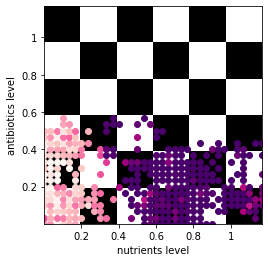

Bacteria Count:  342


In [7]:
height = 36
width = 36
iterations = 15
bac_count = [None] * iterations
print("beginning")
table = board(height, width)
print("bacteria locations:")
table.display()

for i in range(iterations):
    plt.clf()
    clear_output(wait = True)  
    print("iteration number",i+1)
    table.update()
    table.display()
    bac_count[i] = table.get_num_bac()
    time.sleep(1)

Text(0, 0.5, 'Bacteria Count')

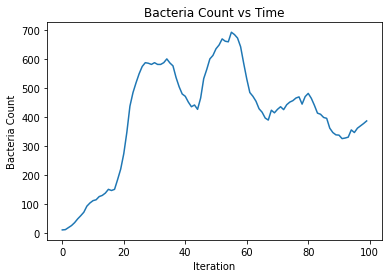

In [13]:
plt.plot(bac_count)
plt.title('Bacteria Count vs Time')
plt.xlabel('Iteration')
plt.ylabel('Bacteria Count')

In [10]:
table._bacteria[35, 35].toxin_gene

15.826993122716807

In [ ]:
#functions aren't implemented with these return types
b = bacteria()

height = 216
width = 216
table = board(height, width)

allbac = []
allbac.append(b)
for ba in range(len(allbac)):
    table.add_bacteria(allbac[ba].x, allbac[ba].y, allbac[ba])
for d in range(50):
    for ba in range(np.size(allbac)):
        newbac = allbac[ba].reproduce(table)
        if newbac:
            allbac.append(newbac)